In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Hyperparameters
BATCH_SIZE  = 1
TARGET_SIZE = (224, 224)
EPOCHS      = 50  # adjust as needed


In [3]:
import os, zipfile, glob
import numpy as np

INPUT_ZIP  = '/content/drive/MyDrive/generated_input.zip'
OUTPUT_ZIP = '/content/drive/MyDrive/generated_target.zip'

def load_npy_from_zip(zip_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)
    # now grab any .npy, even in sub‐folders
    pattern = os.path.join(extract_dir, '**', '*.npy')
    files = sorted(glob.glob(pattern, recursive=True))
    if not files:
        raise ValueError(f"No .npy files found in {extract_dir} after extracting {zip_path}")
    # load & stack
    return np.stack([np.load(f).astype('float32') for f in files], axis=0)

# usage
power_maps = load_npy_from_zip(INPUT_ZIP,  'power_maps')
temp_maps  = load_npy_from_zip(OUTPUT_ZIP, 'temp_maps')

# Subsample power_maps to match the number of samples in temp_maps
power_maps = power_maps[:temp_maps.shape[0]]

print("Loaded shapes:", power_maps.shape, temp_maps.shape)

Loaded shapes: (3624, 224, 224, 5) (3624, 224, 224, 3)


In [4]:
# Slice channel 0 → shape becomes (N,224,224,1)
X = power_maps[..., 0:1]
Y = temp_maps[..., 0:1]

print("power_maps shape before creating dataset:", X.shape)
print("temp_maps shape before creating dataset:", Y.shape)

# 80% train / 20% test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

power_maps shape before creating dataset: (3624, 224, 224, 1)
temp_maps shape before creating dataset: (3624, 224, 224, 1)
Train samples: 2899, Test samples: 725


In [5]:
def make_ds(X, Y, batch_size=BATCH_SIZE, target_size=TARGET_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(
        lambda x, y: (
            tf.image.resize(x, target_size),
            tf.image.resize(y, target_size)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, Y_train)
test_ds  = make_ds(X_test,  Y_test)

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(224,224,1)):
    inputs = Input(shape=input_shape)
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p2)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    merge6 = Concatenate()([u6, c2])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    merge7 = Concatenate()([u7, c1])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='linear')(c7)
    return Model(inputs, outputs)

model = build_unet(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    590,336 │ max_pooling2d_1[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │  2,359,808 │ conv2d_4[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │    524,544 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │    884,992 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 224, 224,  │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │    221,312 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │    147,584 │ conv2d_8[0][0]  

 Total params: 5,708,993 (21.78 MB)

 Trainable params: 5,708,993 (21.78 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
)

In [8]:
import os
ckpt_dir = '/content/drive/MyDrive/multigpu_checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, 'best_model.h5')

# 3) Callback to save only the best model (by val_mae)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=1
)

import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self._start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self._start_time
        self.epoch_times.append(duration)
        thru = X_train.shape[0] / duration
        print(f"→ Epoch {epoch:02d} took {duration:.2f}s, throughput {thru:.1f} samples/s")

time_cb = TimeHistory()

In [9]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[checkpoint_cb, time_cb]
)


Epoch 1/50
2897/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 720.5976 - mae: 8.7560
Epoch 1: val_mae improved from inf to 3.84724, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 00 took 40.15s, throughput 72.2 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 719.9985 - mae: 8.7524 - val_loss: 23.6444 - val_mae: 3.8472
Epoch 2/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.5988 - mae: 4.0684
Epoch 2: val_mae did not improve from 3.84724
→ Epoch 01 took 27.82s, throughput 104.2 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 26.5984 - mae: 4.0684 - val_loss: 35.6506 - val_mae: 4.8698
Epoch 3/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.6905 - mae: 3.8104
Epoch 3: val_mae improved from 3.84724 to 3.50116, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 02 took 29.21s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 23.6901 - mae: 3.8103 - val_loss: 20.3351 - val_mae: 3.5012
Epoch 4/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.9490 - mae: 3.5364
Epoch 4: val_mae improved from 3.50116 to 3.44697, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 03 took 29.19s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 20.9488 - mae: 3.5363 - val_loss: 20.1539 - val_mae: 3.4470
Epoch 5/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.7920 - mae: 3.4011
Epoch 5: val_mae improved from 3.44697 to 3.17279, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 04 took 29.19s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 19.7918 - mae: 3.4011 - val_loss: 17.6532 - val_mae: 3.1728
Epoch 6/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.4293 - mae: 3.2535
Epoch 6: val_mae improved from 3.17279 to 3.03112, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 05 took 29.39s, throughput 98.6 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 18.4292 - mae: 3.2535 - val_loss: 16.4254 - val_mae: 3.0311
Epoch 7/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.3573 - mae: 3.1244
Epoch 7: val_mae improved from 3.03112 to 2.93993, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 06 took 29.09s, throughput 99.7 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 17.3572 - mae: 3.1244 - val_loss: 15.7596 - val_mae: 2.9399
Epoch 8/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.8317 - mae: 3.0529
Epoch 8: val_mae improved from 2.93993 to 2.93515, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 07 took 29.46s, throughput 98.4 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 16.8317 - mae: 3.0529 - val_loss: 15.7470 - val_mae: 2.9351
Epoch 9/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.4765 - mae: 3.0038
Epoch 9: val_mae improved from 2.93515 to 2.87836, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 08 took 29.35s, throughput 98.8 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 16.4764 - mae: 3.0038 - val_loss: 15.3973 - val_mae: 2.8784
Epoch 10/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.2348 - mae: 2.9675
Epoch 10: val_mae improved from 2.87836 to 2.83509, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 09 took 29.14s, throughput 99.5 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 16.2347 - mae: 2.9675 - val_loss: 15.1185 - val_mae: 2.8351
Epoch 11/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.0802 - mae: 2.9431
Epoch 11: val_mae improved from 2.83509 to 2.82607, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 10 took 29.03s, throughput 99.9 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 16.0801 - mae: 2.9431 - val_loss: 15.0822 - val_mae: 2.8261
Epoch 12/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.9621 - mae: 2.9237
Epoch 12: val_mae improved from 2.82607 to 2.80300, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 11 took 29.11s, throughput 99.6 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.9620 - mae: 2.9237 - val_loss: 14.9195 - val_mae: 2.8030
Epoch 13/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.6652 - mae: 2.8860
Epoch 13: val_mae improved from 2.80300 to 2.78782, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 12 took 29.34s, throughput 98.8 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.6651 - mae: 2.8860 - val_loss: 14.8348 - val_mae: 2.7878
Epoch 14/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.5446 - mae: 2.8688
Epoch 14: val_mae improved from 2.78782 to 2.77410, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 13 took 29.13s, throughput 99.5 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.5445 - mae: 2.8688 - val_loss: 14.7468 - val_mae: 2.7741
Epoch 15/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.4500 - mae: 2.8551
Epoch 15: val_mae improved from 2.77410 to 2.75370, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 14 took 29.24s, throughput 99.1 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.4500 - mae: 2.8551 - val_loss: 14.6129 - val_mae: 2.7537
Epoch 16/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.3894 - mae: 2.8448
Epoch 16: val_mae improved from 2.75370 to 2.74091, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 15 took 29.19s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.3894 - mae: 2.8448 - val_loss: 14.5253 - val_mae: 2.7409
Epoch 17/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.3162 - mae: 2.8342
Epoch 17: val_mae did not improve from 2.74091
→ Epoch 16 took 27.98s, throughput 103.6 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 15.3162 - mae: 2.8342 - val_loss: 14.6319 - val_mae: 2.7584
Epoch 18/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.2543 - mae: 2.8216
Epoch 18: val_mae improved from 2.74091 to 2.73812, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 17 took 29.19s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.2542 - mae: 2.8216 - val_loss: 14.4967 - val_mae: 2.7381
Epoch 19/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.1873 - mae: 2.8127
Epoch 19: val_mae did not improve from 2.73812
→ Epoch 18 took 28.03s, throughput 103.4 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 15.1873 - mae: 2.8127 - val_loss: 14.4841 - val_mae: 2.7414
Epoch 20/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.0573 - mae: 2.7943
Epoch 20: val_mae improved from 2.73812 to 2.73768, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 19 took 29.38s, throughput 98.7 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 15.0572 - mae: 2.7943 - val_loss: 14.4582 - val_mae: 2.7377
Epoch 21/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.0418 - mae: 2.7921
Epoch 21: val_mae did not improve from 2.73768
→ Epoch 20 took 27.82s, throughput 104.2 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 15.0418 - mae: 2.7921 - val_loss: 14.5568 - val_mae: 2.7529
Epoch 22/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.9744 - mae: 2.7833
Epoch 22: val_mae did not improve from 2.73768
→ Epoch 21 took 28.01s, throughput 103.5 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.9744 - mae: 2.7833 - val_loss: 14.5602 - val_mae: 2.7535
Epoch 23/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.9630 - mae: 2.7801
Epoch 23: val_mae did not improve from 2.73768
→ Epoch 22 took 27.78s, throughput 104.4 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.9629 -

→ Epoch 30 took 29.23s, throughput 99.2 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7745 - mae: 2.7485 - val_loss: 14.4568 - val_mae: 2.7314
Epoch 32/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.7482 - mae: 2.7434
Epoch 32: val_mae improved from 2.73145 to 2.71547, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 31 took 29.37s, throughput 98.7 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7482 - mae: 2.7434 - val_loss: 14.3696 - val_mae: 2.7155
Epoch 33/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.7143 - mae: 2.7383
Epoch 33: val_mae improved from 2.71547 to 2.71285, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 32 took 29.09s, throughput 99.6 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7142 - mae: 2.7383 - val_loss: 14.3571 - val_mae: 2.7129
Epoch 34/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.7143 - mae: 2.7381
Epoch 34: val_mae improved from 2.71285 to 2.70772, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 33 took 29.19s, throughput 99.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7143 - mae: 2.7381 - val_loss: 14.3255 - val_mae: 2.7077
Epoch 35/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6995 - mae: 2.7355
Epoch 35: val_mae improved from 2.70772 to 2.70184, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 34 took 29.56s, throughput 98.1 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 14.6995 - mae: 2.7355 - val_loss: 14.2944 - val_mae: 2.7018
Epoch 36/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6845 - mae: 2.7326
Epoch 36: val_mae improved from 2.70184 to 2.69419, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 35 took 29.08s, throughput 99.7 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.6845 - mae: 2.7326 - val_loss: 14.2592 - val_mae: 2.6942
Epoch 37/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6811 - mae: 2.7314
Epoch 37: val_mae improved from 2.69419 to 2.68583, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 36 took 29.28s, throughput 99.0 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.6811 - mae: 2.7314 - val_loss: 14.2261 - val_mae: 2.6858
Epoch 38/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.7146 - mae: 2.7349
Epoch 38: val_mae improved from 2.68583 to 2.67963, saving model to /content/drive/MyDrive/multigpu_checkpoints/best_model.h5


→ Epoch 37 took 29.04s, throughput 99.8 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7146 - mae: 2.7349 - val_loss: 14.1831 - val_mae: 2.6796
Epoch 39/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6750 - mae: 2.7299
Epoch 39: val_mae did not improve from 2.67963
→ Epoch 38 took 28.03s, throughput 103.4 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.6750 - mae: 2.7299 - val_loss: 14.1989 - val_mae: 2.6823
Epoch 40/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6161 - mae: 2.7215
Epoch 40: val_mae did not improve from 2.67963
→ Epoch 39 took 27.86s, throughput 104.0 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.6161 - mae: 2.7215 - val_loss: 14.2100 - val_mae: 2.6839
Epoch 41/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.6348 - mae: 2.7242
Epoch 41: val_mae did not improve from 2.67963
→ Epoch 40 took 27.79s, throughput 104.3 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.6348 -

→ Epoch 41 took 29.08s, throughput 99.7 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 14.7054 - mae: 2.7323 - val_loss: 14.1613 - val_mae: 2.6775
Epoch 43/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.5713 - mae: 2.7137
Epoch 43: val_mae did not improve from 2.67753
→ Epoch 42 took 27.87s, throughput 104.0 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.5713 - mae: 2.7137 - val_loss: 14.1817 - val_mae: 2.6795
Epoch 44/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.5780 - mae: 2.7148
Epoch 44: val_mae did not improve from 2.67753
→ Epoch 43 took 27.78s, throughput 104.4 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.5780 - mae: 2.7148 - val_loss: 14.2090 - val_mae: 2.6862
Epoch 45/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.5803 - mae: 2.7155
Epoch 45: val_mae did not improve from 2.67753
→ Epoch 44 took 27.89s, throughput 103.9 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 14.5803 -

→ Epoch 49 took 30.35s, throughput 95.5 samples/s
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 14.5377 - mae: 2.7080 - val_loss: 14.1594 - val_mae: 2.6721


In [10]:
loss, mae = model.evaluate(test_ds)
print(f"Test loss (MSE): {loss:.4f}")
print(f"Test MAE   : {mae:.4f}")


725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.1774 - mae: 2.6777
Test loss (MSE): 14.1594
Test MAE   : 2.6721


In [11]:
import numpy as np

# 1) get raw predictions and ground-truth from the test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# 2) compute mean absolute error in °C
abs_loss = np.mean(np.abs(y_pred - y_true))
print(f"Mean Absolute Error: {abs_loss:.4f} °C")


725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Mean Absolute Error: 2.6721 °C


In [12]:
import time

# a) Warm-up
for x_batch, _ in test_ds.take(1):
    _ = model.predict(x_batch)

# b) Measure over the entire test set
start = time.time()
n = 0
for x_batch, _ in test_ds:
    n += x_batch.shape[0]
    _ = model.predict(x_batch)
elapsed = time.time() - start

throughput = n / elapsed
latency_ms = elapsed / n * 1000

print(f"Test set: {n} samples in {elapsed:.2f}s")
print(f"→ Throughput: {throughput:.2f} samples/s")
print(f"→ Avg latency: {latency_ms:.2f} ms/sample")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [13]:
# A quick rule-of-thumb: ~2 × total trainable parameters
total_params = model.count_params()
flops_approx = 2 * total_params
print(f"Approximate FLOPs per inference: {flops_approx:,}")

Approximate FLOPs per inference: 11,417,986


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


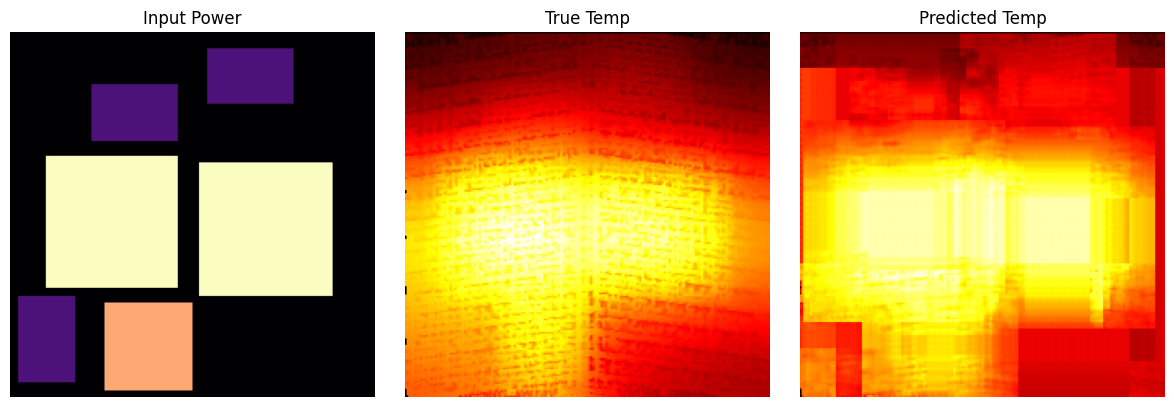

In [14]:
import matplotlib.pyplot as plt

# Take one batch from the test dataset and plot input, truth, and prediction
for x_batch, y_batch in test_ds.take(1):
    # Run the model to get the prediction
    y_pred_batch = model.predict(x_batch)

    # Extract the single sample and its single channel
    input_power = x_batch[0, ..., 0]
    true_temp   = y_batch[0, ..., 0]
    pred_temp   = y_pred_batch[0, ..., 0]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(
        axes,
        [input_power, true_temp, pred_temp],
        ['Input Power', 'True Temp', 'Predicted Temp']
    ):
        ax.imshow(img, cmap='magma' if 'Power' in title else 'hot')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break


In [24]:
import os
import glob
import numpy as np
from collections import defaultdict

# ─── ASSUMES ───────────────────────────────────────────────────────────────────
# • You’ve already mounted your Drive and loaded your multi-GPU UNet into `model`.
# • Your inputs are *_inp.npy and targets are *_out.npy in the folders below.
# ────────────────────────────────────────────────────────────────────────────────

# Paths
drive_root    = "/content/drive/MyDrive"
inp_dir       = os.path.join(drive_root, "datasets/dataset_test/inputs")
gt_dir        = os.path.join(drive_root, "datasets/dataset_test/targets")
results_root  = os.path.join(drive_root, "AI_Temperature", "RESULTS_DAC", "multi_gpu_on_others")
gt_save_dir   = os.path.join(results_root, "gt")
pred_save_dir = os.path.join(results_root, "pred")
os.makedirs(gt_save_dir,   exist_ok=True)
os.makedirs(pred_save_dir, exist_ok=True)

heat_value    = 950.0
test_prefixes = ['ascend910', 'micro150']

# Get your UNet's expected input shape
_, H, W, C = model.input_shape  # e.g. (None, 224, 224, 1)

results = defaultdict(lambda: {'mae': [], 'rmse': [], 'r2': []})

def eval_sample_keras(model, inp_np, gt_np):
    # ─── build single-channel input ─────────────────────────────────────────────
    power = inp_np[..., 0].astype(np.float32)          # take only channel-0
    x     = power.reshape((1, H, W, 1))                # (1, H, W, 1)
    pred  = model.predict(x)[0, ..., 0]                # (H, W)
    # ─── prepare GT ─────────────────────────────────────────────────────────────
    gt = gt_np.astype(np.float32)
    if gt.ndim == 3:
        gt = gt[..., 0]                                # collapse to (H, W)
    # ─── compute metrics ────────────────────────────────────────────────────────
    mae   = np.mean(np.abs(pred - gt))
    rmse  = np.sqrt(np.mean((pred - gt)**2))
    ss_res= np.sum((pred - gt)**2)
    ss_tot= np.sum((gt   - gt.mean())**2)
    r2    = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return pred, gt, mae, rmse, r2

# ─── EVALUATION LOOP ────────────────────────────────────────────────────────────
for inp_path in sorted(glob.glob(os.path.join(inp_dir, "*_inp.npy"))):
    base = os.path.basename(inp_path)[:-4]  # e.g. "ascend910_00020_inp"
    if not any(base.startswith(p) for p in test_prefixes):
        continue

    gt_filename = base.replace("_inp", "_out") + ".npy"
    gt_path     = os.path.join(gt_dir, gt_filename)
    if not os.path.exists(gt_path):
        print(f"⚠️ missing GT for {base} (looking for {gt_filename})")
        continue

    inp_np = np.load(inp_path)
    gt_np  = np.load(gt_path)
    pred, gt, mae, rmse, r2 = eval_sample_keras(model, inp_np, gt_np)

    # save GT & prediction arrays
    np.save(os.path.join(gt_save_dir,   gt_filename),    gt)
    pred_filename = base.replace("_inp", "_pred") + ".npy"
    np.save(os.path.join(pred_save_dir, pred_filename), pred)

    # accumulate metrics
    prefix = next(p for p in test_prefixes if base.startswith(p))
    results[prefix]['mae'].append(mae)
    results[prefix]['rmse'].append(rmse)
    results[prefix]['r2'].append(r2)

# ─── PRINT RESULTS ──────────────────────────────────────────────────────────────
print("\n=== multi_gpu UNet tested on ascend910 & micro150 ===")
for p in test_prefixes:
    if results[p]['mae']:
        print(f"{p:12s} | MAE: {np.mean(results[p]['mae']):.4f}  "
              f"RMSE: {np.mean(results[p]['rmse']):.4f}  "
              f"R²: {np.mean(results[p]['r2']):.4f}")
    else:
        print(f"{p:12s} | no samples found")

all_mae  = np.hstack([results[p]['mae']  for p in test_prefixes if results[p]['mae']])
all_rmse = np.hstack([results[p]['rmse'] for p in test_prefixes if results[p]['rmse']])
all_r2   = np.hstack([results[p]['r2']   for p in test_prefixes if results[p]['r2']])
print(f"\nOverall   | MAE: {all_mae.mean():.4f}  "
      f"RMSE: {all_rmse.mean():.4f}  "
      f"R²: {all_r2.mean():.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━